# EDA部分

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', None)

dataPath = 'C:/Users/zhang/mine/finTech/2021/data/A'

trainDf = pd.read_csv(dataPath + '/train_v1.csv')
wkdDf = pd.read_csv(dataPath + '/wkd_v1.csv')
testDf = pd.read_csv(dataPath + '/test_v1_periods.csv')
testDayDf = pd.read_csv(dataPath + '/test_v1_day.csv')

wkdDf = wkdDf.rename(columns={'ORIG_DT':'date'})

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
######### 这里数据官方已清洗过
trainDf = trainDf.merge(wkdDf, on = ['date'], how = 'left')
testDf = testDf.merge(wkdDf, on = ['date'], how = 'left')
testDayDf = testDayDf.merge(wkdDf, on = ['date'], how = 'left')

trainDf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 695520 entries, 0 to 695519
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   date        695520 non-null  object
 1   post_id     695520 non-null  object
 2   biz_type    695520 non-null  object
 3   periods     695520 non-null  int64 
 4   amount      695520 non-null  int64 
 5   WKD_TYP_CD  695520 non-null  object
dtypes: int64(2), object(4)
memory usage: 37.1+ MB


In [3]:
trainDf.head()

,date,post_id,biz_type,periods,amount,WKD_TYP_CD
0,2018/1/1,A,A1,1,0,NH
1,2018/1/1,A,A1,2,0,NH
2,2018/1/1,A,A1,3,0,NH
3,2018/1/1,A,A1,4,0,NH
4,2018/1/1,A,A1,5,0,NH


In [4]:
#将A/B岗位拆分出来分别分析，以天为粒度
## 提取岗位以日为粒度的业务量
def get_jobDayAmount(df):
    outputDf = df.groupby(['date', 'post_id', 'WKD_TYP_CD'], as_index = False)['amount'].sum()
    return outputDf

tmp = get_jobDayAmount(trainDf)
train_day_df=pd.DataFrame(tmp).reset_index()
train_day_df_A=train_day_df[train_day_df['post_id']=='A'].reset_index(drop=True)
train_day_df_B=train_day_df[train_day_df['post_id']=='B'].reset_index(drop=True)
#train_day_df_A=train_day_df_A.merge(wkd_df)
#train_day_df_B=train_day_df_B.merge(wkd_df)
#
def get_frt(df):
    df['WKD_TYP_CD']=df['WKD_TYP_CD'].map({'WN':0,'SN': 1, 'NH': 1, 'SS': 1, 'WS': 0})
    df['date'] = pd.to_datetime(df['date'], format = '%Y/%m/%d')
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df.drop(['date','post_id'],axis=1,inplace=True)
    return df
train_day_df_A=get_frt(train_day_df_A)
train_day_df_B=get_frt(train_day_df_B)

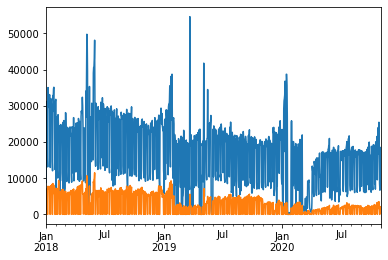

In [5]:
ts = pd.Series(train_day_df_A['amount'].values, index=pd.date_range("1/1/2018", periods=len(train_day_df_A['amount'].values)))
ts.plot()
ts = pd.Series(train_day_df_B['amount'].values, index=pd.date_range("1/1/2018", periods=len(train_day_df_B['amount'].values)))
ts.plot()

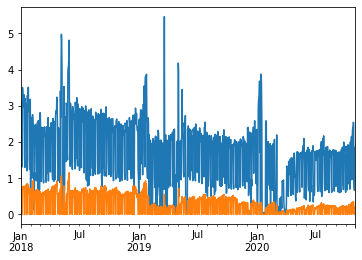

In [6]:
## 数据比较大，除以1e4
train_day_df_A['amount']=train_day_df_A['amount']/1e4
train_day_df_B['amount']=train_day_df_B['amount']/1e4

ts = pd.Series(train_day_df_A['amount'].values, index=pd.date_range("1/1/2018", periods=len(train_day_df_A['amount'].values)))
ts.plot()
ts = pd.Series(train_day_df_B['amount'].values, index=pd.date_range("1/1/2018", periods=len(train_day_df_B['amount'].values)))
ts.plot()

对于A：

- 可以看到18/10--18/11月增加了(59.1890-54.6016)/54.6016=8.4%
- 可以看到19/10--19/11月增加了(46.6275-44.9047)/44.9047=3.8%

对于B:

- 可以看到18/10--18/11月增加了(12.88-11.72)/11.72=9.9%
- 可以看到19/10--19/11月增加了(3.793-3.625)/3.625=4.6% 

18-19年月份之间的趋势变化基本一致，20年因为疫情影响，数值的绝对值在变化， 但是趋势并未变化，如果以年份来看的话周期性十分明显。

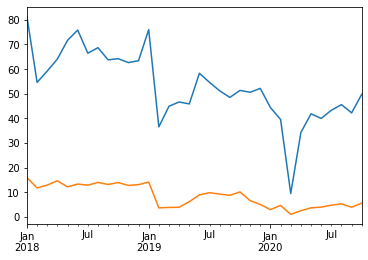

In [7]:
#A按照year/month进行group,看看每一年中每一个月的变化
group_year_month_A=train_day_df_A[['year','month','amount']].groupby(['year','month'],sort=False).agg(['sum'])
group_year_month_A=pd.DataFrame(group_year_month_A).reset_index()
group_year_month_A.columns=['year','month','amount']
ts = pd.Series(group_year_month_A['amount'].values, index=pd.date_range("1/2018", periods=len(group_year_month_A['amount'].values),freq="M"))
ts.plot()
#B按照year/month进行group,看看每一年中每一个月的变化
group_year_month_B=train_day_df_B[['year','month','amount']].groupby(['year','month'],sort=False).agg(['sum'])
group_year_month_B=pd.DataFrame(group_year_month_B).reset_index()
group_year_month_B.columns=['year','month','amount']
ts = pd.Series(group_year_month_B['amount'].values, index=pd.date_range("1/2018", periods=len(group_year_month_B['amount'].values),freq="M"))
ts.plot()

## 分析18/19两年11月份的每一天的趋势
- 如果只看day和amount的趋势，18/19各自11月份的变化趋势和天数关系其实不大
- 但通过分析WKD_TYP_CD可以明显看到，11月份只有两种WKD_TYP_CD:WN/SN，当为WN时，业务量明显高于SN.这也是符合常识的
- 20年11月份的WKD_TYP_CD也只有WN/SN两种情形，所以我们只需要考虑WN和SN对amount的影响
    - 这里最朴素的想法是统计18，19年11月0,1对应的每一天的amount占一个月的比例

0.039263975646580525
0.041519039209704095
0.017024066971903565
0.014233352955134861


'\n0.03926397564658053\n0.0415190392097041\n0.017024066971903562\n0.014233352955134861\n所以如果得到20年11月份的总业务量nov_2020\nnov_2020*(0.039+0.041)/2 if 当前day的WKD_TYP_CD==0\nnov_2020*(0.017+0.014)/2 if 当前day的WKD_TYP_CD==1\n'

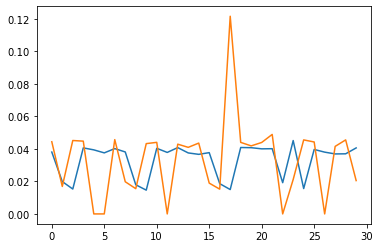

In [8]:
nov_month=train_day_df_A[train_day_df_A['month']==11]
nov_month_18=nov_month[nov_month['year']==2018][['WKD_TYP_CD','amount']].reset_index(drop=True)
nov_month_19=nov_month[nov_month['year']==2019][['WKD_TYP_CD','amount']].reset_index(drop=True)
nov_month_18['amount']/=np.sum(nov_month_18['amount'])
nov_month_19['amount']/=np.sum(nov_month_19['amount'])
nov_month_18['amount'].plot()
nov_month_19['amount'].plot()
print(nov_month_18[nov_month_18['WKD_TYP_CD']==0]['amount'].mean())
print(nov_month_19[nov_month_19['WKD_TYP_CD']==0]['amount'].mean())
print(nov_month_18[nov_month_18['WKD_TYP_CD']==1]['amount'].mean())
print(nov_month_19[nov_month_19['WKD_TYP_CD']==1]['amount'].mean())
'''
0.03926397564658053
0.0415190392097041
0.017024066971903562
0.014233352955134861
所以如果得到20年11月份的总业务量nov_2020
nov_2020*(0.039+0.041)/2 if 当前day的WKD_TYP_CD==0
nov_2020*(0.017+0.014)/2 if 当前day的WKD_TYP_CD==1
'''

In [9]:
train_day_df_A.shape

(1035, 6)

In [10]:
train_day_df_B.shape

(1035, 6)

## 具体某一天的趋势

In [20]:
def get_date(df):
    df['WKD_TYP_CD']=df['WKD_TYP_CD'].map({'WN':0,'SN': 1, 'NH': 1, 'SS': 1, 'WS': 0})
    df['date'] = pd.to_datetime(df['date'], format = '%Y/%m/%d')
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    return df

def get_jobPeriodAmount(df):
    outputDf = df.groupby(['date', 'post_id', 'periods', 'WKD_TYP_CD'], as_index = False)['amount'].sum()
    return outputDf


In [21]:
tmp = get_jobPeriodAmount(trainDf)
tmp = get_date(tmp)
tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99360 entries, 0 to 99359
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        99360 non-null  datetime64[ns]
 1   post_id     99360 non-null  object        
 2   periods     99360 non-null  int64         
 3   WKD_TYP_CD  99360 non-null  int64         
 4   amount      99360 non-null  int64         
 5   year        99360 non-null  int64         
 6   month       99360 non-null  int64         
 7   day         99360 non-null  int64         
dtypes: datetime64[ns](1), int64(6), object(1)
memory usage: 6.8+ MB


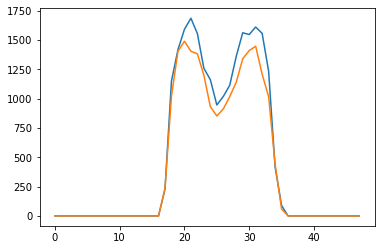

In [24]:
nov_month=tmp[(tmp['month']==11) & (tmp['day']==1) & (tmp['post_id']=='A')]
nov_month_18=nov_month[nov_month['year']==2018][['periods','amount']].reset_index(drop=True)
nov_month_19=nov_month[nov_month['year']==2019][['periods','amount']].reset_index(drop=True)
#nov_month_18['amount']/=np.sum(nov_month_18['amount'])
#nov_month_19['amount']/=np.sum(nov_month_19['amount'])
nov_month_18['amount'].plot()
nov_month_19['amount'].plot()

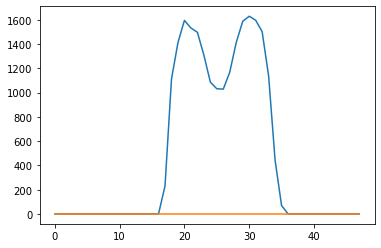

In [26]:
nov_month=tmp[(tmp['month']==11) & (tmp['day']==2) & (tmp['post_id']=='A')]
nov_month_18=nov_month[nov_month['year']==2018][['periods','amount']].reset_index(drop=True)
nov_month_19=nov_month[nov_month['year']==2019][['periods','amount']].reset_index(drop=True)
#nov_month_18['amount']/=np.sum(nov_month_18['amount'])
#nov_month_19['amount']/=np.sum(nov_month_19['amount'])
nov_month_18['amount'].plot()
nov_month_19['amount'].plot()

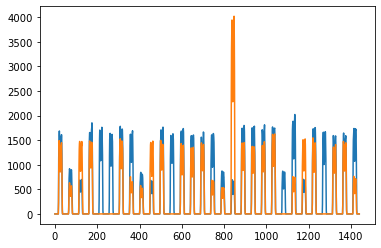

In [34]:
nov_month=tmp[(tmp['month']==11) & (tmp['post_id']=='A')]
nov_month_18=nov_month[nov_month['year']==2018][['day', 'periods','amount']].reset_index(drop=True)
nov_month_19=nov_month[nov_month['year']==2019][['day', 'periods','amount']].reset_index(drop=True)
#nov_month_18['amount']/=np.sum(nov_month_18['amount'])
#nov_month_19['amount']/=np.sum(nov_month_19['amount'])
nov_month_18['amount'].plot()
nov_month_19['amount'].plot()


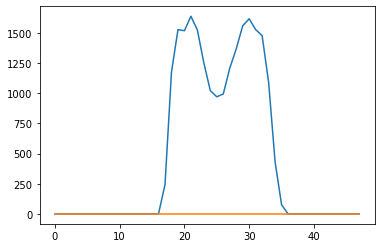

In [35]:
nov_month=tmp[(tmp['month']==11) & (tmp['day']==14) & (tmp['post_id']=='A')]
nov_month_18=nov_month[nov_month['year']==2018][['periods','amount']].reset_index(drop=True)
nov_month_19=nov_month[nov_month['year']==2019][['periods','amount']].reset_index(drop=True)
#nov_month_18['amount']/=np.sum(nov_month_18['amount'])
#nov_month_19['amount']/=np.sum(nov_month_19['amount'])
nov_month_18['amount'].plot()
nov_month_19['amount'].plot()

In [36]:
nov_month_18

,periods,amount
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
5,6,0
6,7,0
7,8,0
8,9,0
9,10,0
